In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [3]:
!ls /g/data/ua8/LE_models/20CRv3/mean_daily/prmsl

prmsl.1836.nc  prmsl.1872.nc  prmsl.1908.nc  prmsl.1944.nc  prmsl.1980.nc
prmsl.1837.nc  prmsl.1873.nc  prmsl.1909.nc  prmsl.1945.nc  prmsl.1981.nc
prmsl.1838.nc  prmsl.1874.nc  prmsl.1910.nc  prmsl.1946.nc  prmsl.1982.nc
prmsl.1839.nc  prmsl.1875.nc  prmsl.1911.nc  prmsl.1947.nc  prmsl.1983.nc
prmsl.1840.nc  prmsl.1876.nc  prmsl.1912.nc  prmsl.1948.nc  prmsl.1984.nc
prmsl.1841.nc  prmsl.1877.nc  prmsl.1913.nc  prmsl.1949.nc  prmsl.1985.nc
prmsl.1842.nc  prmsl.1878.nc  prmsl.1914.nc  prmsl.1950.nc  prmsl.1986.nc
prmsl.1843.nc  prmsl.1879.nc  prmsl.1915.nc  prmsl.1951.nc  prmsl.1987.nc
prmsl.1844.nc  prmsl.1880.nc  prmsl.1916.nc  prmsl.1952.nc  prmsl.1988.nc
prmsl.1845.nc  prmsl.1881.nc  prmsl.1917.nc  prmsl.1953.nc  prmsl.1989.nc
prmsl.1846.nc  prmsl.1882.nc  prmsl.1918.nc  prmsl.1954.nc  prmsl.1990.nc
prmsl.1847.nc  prmsl.1883.nc  prmsl.1919.nc  prmsl.1955.nc  prmsl.1991.nc
prmsl.1848.nc  prmsl.1884.nc  prmsl.1920.nc  prmsl.1956.nc  prmsl.1992.nc
prmsl.1849.nc  prmsl.1885.nc  prmsl.19

In [4]:
path_p = '/g/data/ua8/LE_models/20CRv3/mean_daily/prmsl/*.nc'

## skip this section as the below cells read in the data and save as netcdf (which has already been done)

In [ ]:
# read in daily mean sea level pressure (mean across all 20CR members)
P_ds = xr.open_mfdataset(path_p)
del P_ds['time_bnds']
P_ds

In [ ]:
# resample to monthly
P_mon = P_ds.resample(time='M').min(dim='time')
P_mon

In [ ]:
with dask.diagnostics.ProgressBar():
    P_mon.to_netcdf('MSLP_mon.nc')

P*40�S and P*65�S are the normalized monthly zonal sea level pressure (SLP) at 40�S and 65�S
The 30-year period from 1971-2000 is used for the normalization period. Note that this period is arbitrary and a switch to a different period would change the exact SAM values but would be unlikely to significantly alter any trends.
(true zonal mean was simply the mean of the 144 points along the appropriate parallel)

# need to normalise P40 and should probs save PRMSL monthly as a netcdf and also maybe SAM

In [5]:
# read in netcdf of monthly pressure
P_mon_ds = xr.open_dataset('MSLP_mon.nc')

In [6]:
# calculate the zonal mean mslp at 40 and 65S (to be used in calculating SAM)
P40S = P_mon_ds.sel(lat=-40).mean(dim='lon')
P65S = P_mon_ds.sel(lat=-65).mean(dim='lon')
P65S

<xarray.Dataset>
Dimensions:  (time: 2160)
Coordinates:
  * time     (time) datetime64[ns] 1836-01-31 1836-02-29 ... 2015-12-31
    lat      float32 -65.0
Data variables:
    prmsl    (time) float32 9.88e+04 9.872e+04 9.846e+04 ... 9.592e+04 9.68e+04

In [7]:
# set the dates for the normalisation period
start_date = '1971'
end_date = '2000'

In [9]:
# calculate the anomaly for the normalised zonal mean, x, (x-mean)/std
anom40 = func.monthly_anomaly(P40S, start_date, end_date)
anom65 = func.monthly_anomaly(P65S, start_date, end_date)
anom65

<xarray.Dataset>
Dimensions:  (time: 2160)
Coordinates:
  * time     (time) datetime64[ns] 1836-01-31 1836-02-29 ... 2015-12-31
    lat      float32 -65.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    prmsl    (time) float32 1.437e+03 1.797e+03 1.856e+03 ... -868.9 -471.2

In [10]:
# calculate the std for the normalised zonal mean, x, (x-mean)/std
std40 = anom40.sel(time=slice(start_date, end_date)).std(dim='time')
std65 = anom65.sel(time=slice(start_date, end_date)).std(dim='time')
std40

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float32 -40.0
Data variables:
    prmsl    float64 178.9

In [11]:
# normalise the pressure values by minusing the mean (ie calculating anomaly) and dividing by 30-year average
P40S_n = anom40/std40
P65S_n = anom65/std65

In [12]:
# calculate the SAM index by finding the normalised pressure difference between the two latitude bands
SAM = P40S_n - P65S_n
SAM

<xarray.Dataset>
Dimensions:  (time: 2160)
Coordinates:
  * time     (time) datetime64[ns] 1836-01-31 1836-02-29 ... 2015-12-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    prmsl    (time) float64 1.701 0.5813 1.714 2.078 ... -0.6553 1.869 0.5343

# figures

In [15]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [26]:
e_date = ['1883-08-27']

[Text(-5479.0, 0, '1955'),
 Text(-3653.0, 0, '1960'),
 Text(-1826.0, 0, '1965'),
 Text(0.0, 0, '1970'),
 Text(1826.0, 0, '1975'),
 Text(3652.0, 0, '1980'),
 Text(5479.0, 0, '1985'),
 Text(7305.0, 0, '1990'),
 Text(9131.0, 0, '1995'),
 Text(10957.0, 0, '2000'),
 Text(12784.0, 0, '2005'),
 Text(14610.0, 0, '2010'),
 Text(16436.0, 0, '2015')]

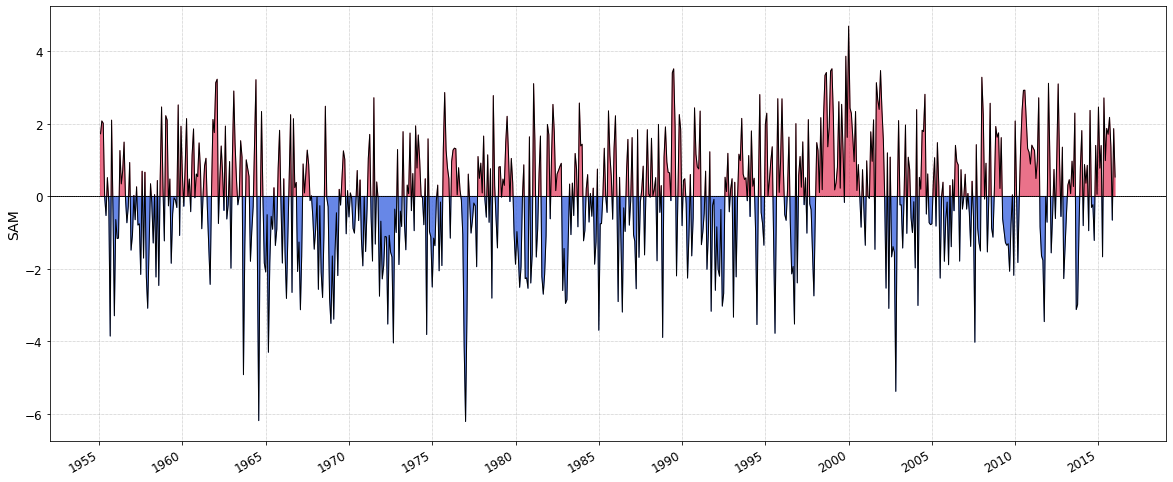

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(20,8))

start_date, end_date = '1955','2015'
ds = SAM.prmsl.sel(time=slice(start_date, end_date))
fplot.SAM_plot(ds, ax = axes)

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='5YS')
axes.set_xticks(years.values)
axes.set_xticklabels(years.year) # .year shows only the year (not month)

# plt.savefig('R_timeseries_mon_SAM_compare.png', dpi=300, bbox_inches='tight')

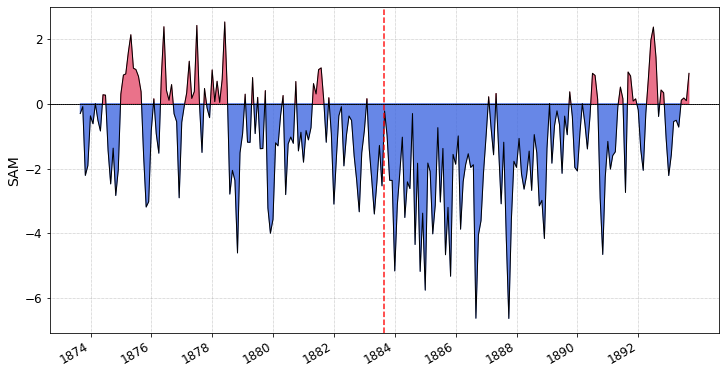

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(12,6))

# select the dataset and years to plot
start_date, end_date = '1873-08','1893-08'
ds = SAM.prmsl.sel(time=slice(start_date, end_date))

# plot the SAM index
fplot.SAM_plot(ds, ax = axes, e_date=e_date)

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='2YS')
axes.set_xticks(years.values)
axes.set_xticklabels(years.year) # .year shows only the year (not month)

plt.savefig('R_K_timeseries_mon_SAM.png', dpi=300, bbox_inches='tight')

Negative SAM: westerly winds further north than usual.  This brings more precipitation to southwest and southeast in winter and less precipitation in parts of the east, so it is likely to be wetter in Victoria, but dry in New South Wales. There is also an increased chance of snow in alpine areas.  In summer, a negative SAM causes a decreased likelihood of precipitation in the southeast and east and a greater chance of spring heatwaves in sourthern australia.  Th
In EL Ninos SAM tends to be more negative particularly in spring and summer. This enhances El Nino signals.    

(citation: http://www.bom.gov.au/climate/sam/#tabs=What-is-SAM%3F) 

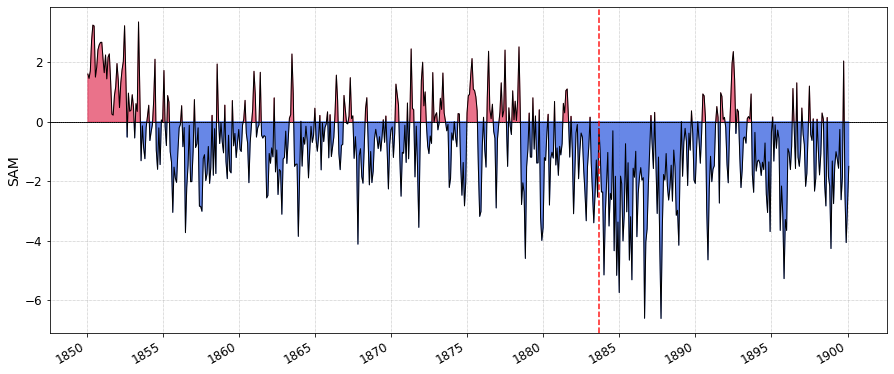

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(15,6))

# select the dataset and years to plot
start_date, end_date = '1850-01','1900-01'
ds = SAM.prmsl.sel(time=slice(start_date, end_date))

# plot the SAM index
fplot.SAM_plot(ds, ax = axes, e_date=e_date)

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='5YS')
axes.set_xticks(years.values)
axes.set_xticklabels(years.year) # .year shows only the year (not month)

plt.savefig('R_timeseries_mon_SAM.png', dpi=300, bbox_inches='tight')